In [1]:
import os
import random
import mlflow
import numpy as np
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Data Engineering

In [18]:
df = pd.read_csv("./widsdatathon2022/train.csv")
df_test = pd.read_csv("./widsdatathon2022/test.csv")

In [19]:
df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


<font style='color:skyblue'>Because the data set is big, with MLFlow, the produced files will be too large to be able to upload to the GitHub repository, here we will select the first 1000 instances of the training data set to train the model. Thus, the performance of our model will not be as good as one trained with full data set.</font>

In [4]:
X = df.copy()
y = pd.DataFrame(X.loc[:1000,'site_eui'], columns=['site_eui'])
X = X.drop('site_eui', axis = 1)
X = X.loc[:1000,:]
X.drop('id', axis = 1, inplace = True)

### Split the data into training, validation, and testing sets.

In [5]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.1, random_state=42)

In [6]:
cat_cols = Xtrain.select_dtypes(include='object').columns
num_cols = Xtrain.drop(columns = cat_cols).columns

## Machine Learning Models
### Random Forest Tree Model
Because we have repeated patterns in numerical features. We decided to use random forest tree model. The random forest tree model can help us determine the importance of these features in the mean time of prediction.

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def train_model(train_df, max_depth=2):
    X = train_df.copy()
    y = pd.DataFrame(X.loc[:1000,'site_eui'], columns=['site_eui'])
    X = X.drop('site_eui', axis = 1)
    X = X.loc[:1000,:]
    X.drop('id', axis = 1, inplace = True)
    
    # Split data
    Xtrain = X
    ytrain = y
    X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=42)
    cat_cols = Xtrain.select_dtypes(include='object').columns
    num_cols = Xtrain.drop(columns=cat_cols).columns
    # Fit model
    model = RandomForestRegressor(max_depth=max_depth)
    model.fit(X_train[num_cols].fillna(0), y_train)
    # Evaluate the model
    y_pred = model.predict(X_test[num_cols].fillna(0))
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Test mse = {mse:.2f}, Test RMSE = {rmse:.2f}, Random forest max depth = {max_depth}")
    return model, mse, rmse


# clf = RandomForestRegressor()
# clf.fit(Xtrain[num_cols].fillna(0), ytrain)


In [29]:
clf, mse, rmse = train_model(df, max_depth=2)

Test mse = 2543.75, Test RMSE = 50.44, Random forest max depth = 2


/var/folders/pg/t33xxggd1cndkk5fsb62rs_40000gn/T/ipykernel_28041/3999762109.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train[num_cols].fillna(0), y_train)


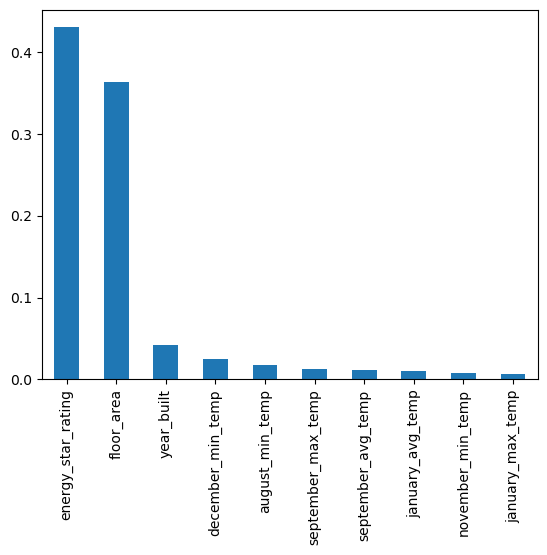

In [30]:
%matplotlib inline
importances = clf.feature_importances_
forest_importances = pd.Series(importances, index = num_cols).sort_values(ascending=False)[:10]
forest_importances.plot.bar()


### Save the RF model with mlflow

In [32]:
from mlflow import MlflowClient

def train_model(train_df, max_depth=2):
    with mlflow.start_run():
        # Split data
        X = train_df.copy()
        y = pd.DataFrame(X.loc[:1000,'site_eui'], columns=['site_eui'])
        X = X.drop('site_eui', axis = 1)
        X = X.loc[:1000,:]
        X.drop('id', axis = 1, inplace = True)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        cat_cols = Xtrain.select_dtypes(include='object').columns
        num_cols = Xtrain.drop(columns=cat_cols).columns
        # Fit model
        model = RandomForestRegressor(max_depth=max_depth)
        model.fit(X_train[num_cols].fillna(0), y_train)
        ## mlflow: log model & its hyper-parameters
        mlflow.log_param("max_depth", max_depth)
        mlflow.sklearn.log_model(model, "model")

        # Evaluate the model
        y_pred = model.predict(X_test[num_cols].fillna(0))
        mse = mean_squared_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        ## mlflow: log metrics
        mlflow.log_metrics({"testing_mse": mse, "testing_rmse": rmse})
        print(f"Test mse = {mse:.2f}, Test RMSE = {rmse:.2f}, Random forest max depth = {max_depth}")

# def fetch_logged_data(run_id):
#     client = MlflowClient()
#     data = client.get_run(run_id).data
#     tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
#     artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
#     return data.params, data.metrics, tags, artifacts

# mlflow.sklearn.autolog()

# with mlflow.start_run() as run:
#     clf.fit(Xtrain[num_cols].fillna(0), ytrain)
    
# params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

In [33]:
for max_depth in range(2, 7, 2):
    _ = train_model(df, max_depth=max_depth)

/var/folders/pg/t33xxggd1cndkk5fsb62rs_40000gn/T/ipykernel_28041/2140515559.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train[num_cols].fillna(0), y_train)
/Users/lin.yang/miniconda3/envs/aimd/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/var/folders/pg/t33xxggd1cndkk5fsb62rs_40000gn/T/ipykernel_28041/2140515559.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train[num_cols].fillna(0), y_train)


Test mse = 2538.62, Test RMSE = 50.38, Random forest max depth = 2
Test mse = 2239.08, Test RMSE = 47.32, Random forest max depth = 4


/var/folders/pg/t33xxggd1cndkk5fsb62rs_40000gn/T/ipykernel_28041/2140515559.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train[num_cols].fillna(0), y_train)


Test mse = 2068.76, Test RMSE = 45.48, Random forest max depth = 6
